![ibm-cloud.png](attachment:ibm-cloud.png)

# CASE STUDY - topic modeling and feature engineering


[Feature engineering](https://en.wikipedia.org/wiki/Feature_engineering) is the process of using domain knowledge of your data to create features that can be leveraged by machine learning.  That is not a hard definition, because sometimes it is used in a context where features are transformed for machine learning, but the inclusion of domain knowledge is not implied.  

It is unfortunately common that for large datasets engineered features are not easy to create.  When there are many features generally only a small number play an important roll when it comes to prediction.  Furthermore,  domain insight is even more difficult to fold into the model when there are hundreds or thousands of features to keep in mind.  However, there is a middle ground---much of the worlds knowledge is locked up in language.  In this case study we will use topic modeling to gather insight from text.  Ideally, the result of these types of experiments would be shared with domain experts to further engineer features that are relevant when it comes to your business opportunity.

In [1]:
%%capture
pip install -U pip

In [2]:
%%capture
pip install pyLDAvis

In [3]:
%%capture
import nltk
nltk.download('wordnet')
nltk.download('punkt')

In [4]:
import os
import re
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from string import punctuation, printable
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

try:
    import pyLDAvis
    import pyLDAvis.sklearn
except:
    raise Exception("'pip install pyldavis' before running this notebook")

pyLDAvis.enable_notebook()    
plt.style.use('seaborn')
%matplotlib inline

DATA_DIR = os.path.join("","/content")

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


## Synopsis

   >Goal:  AAVAIL has recently enabled comments on the core streaming service.  The data science team knows that   this will be an incredibly important source of data going forward.  It will be used inform customer retention, product quality, product market fit and more.  Comments are going live next week and being the diligent data scientist that you are your plan is to build a topic modeling pipeline that will consume the comments and create visualizations that can be used to communicate with domain experts.
  
## Outline

1. EDA - summary tables, use tSNE to visualize the data
2. Create a transfomation pipelines for NMF and LDA
3. Use ldaviz and wordclouds to get insight into the clusters

## Data

Even before receiving the first comment, we want to start building our Pipeline using a proxy dataset. In this study Case we will work with a dataset publicly available dataset of movie reviews.

* [Here](http://www.nltk.org/nltk_data) is the web page that references all the public dataset that NLTK provide. In this Study Case we will work with the 'Sentiment Polarity Dataset Version 2.0' dataset. (The dataset has already been downloaded and is in the data folder of the working directory)
* For more examples of applications with these data see [NLTK's book chapter that uses these data](https://www.nltk.org/book/ch06.html)

In [5]:
filename = os.path.join(DATA_DIR, 'movie_reviews.csv')
df = pd.read_csv(filename)
X = df['review'].tolist()
print(X[4])

b"kolya is one of the richest films i've seen in some time . \nzdenek sverak plays a confirmed old bachelor ( who's likely to remain so ) , who finds his life as a czech cellist increasingly impacted by the five-year old boy that he's taking care of . \nthough it ends rather abruptly-- and i'm whining , 'cause i wanted to spend more time with these characters-- the acting , writing , and production values are as high as , if not higher than , comparable american dramas . \nthis father-and-son delight-- sverak also wrote the script , while his son , jan , directed-- won a golden globe for best foreign language film and , a couple days after i saw it , walked away an oscar . \nin czech and russian , with english subtitles . \n"


### QUESTION 1

The main focus of this exercise is to enable visualization of topics, but these topics can be used as additional 
features for prediction tasks.  The goal of this case study is to ensure that you are comfortable with natural language processing pipelines and topic modeling tools. 

There are many ways to process tokens (words, dates, emojis etc).  NLTK is often used to pre-process text data before the tokens are vectorized.  Generally, the tokens are modified via [stemming or lemmatization](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html).  The next code block provides a lemmatization function that makes use of the library [spacy](https://spacy.io/).  You will need to install it and download the English language reference material as follows.  Stopwords are words that are very common or otherwise irrelevant we use a default list here, but it is an important part of NLP pipelines that needs to be customized for the subject area. Use the following function to process the corpus (this can take a few minutes)

```bash
~$ pip install spacy
~$ python -m spacy download en
```

If you prefer to use NLTK then you could use a simple lemmatizer like the WordLemmatizer.

In [6]:
import spacy
STOPLIST = ENGLISH_STOP_WORDS
STOPLIST = set(list(STOPLIST) + ["foo", "film", "movie", "make"])

if not 'nlp' in locals():
    print("Loading English Module...")
    nlp = spacy.load('en_core_web_sm')

def lemmatize_document(doc, stop_words=None):
    """
    takes a list of strings where each string is a document
    returns a processed list of strings
    """
    
    if not stop_words:
        stop_words = set([])
  
    ## ensure working with string
    doc = str(doc)
    doc = doc.replace('\\n','')
    doc = doc.replace('\\t','')

    # First remove punctuation form string
    if sys.version_info.major == 3:
        PUNCT_DICT = {ord(punc): None for punc in punctuation}
        doc = doc.translate(PUNCT_DICT)

    # remove unicode
    clean_doc = "".join([char for char in doc if char in printable])
            
    # Run the doc through spaCy
    doc = nlp(clean_doc)

    # Lemmatize and lower text
    tokens = [re.sub(r"\W+","",token.lemma_.lower()) for token in doc ]
    tokens = [t for t in tokens if len(t) > 1]
    
    return ' '.join(w for w in tokens if w not in stop_words)    

## example usage
corpus = ['"You can fool some of the people all of the time, and all of the people some of the time, but you can not fool all of the people all of the time". -- Abraham Lincoln']
processed = [lemmatize_document(doc, STOPLIST) for doc in corpus]
print(processed[0])
processed = [lemmatize_document(doc, None) for doc in corpus]
print("\n"+processed[0])

Loading English Module...


/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:126: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):


pron fool people time people time pron fool people time abraham lincoln

pron can fool some of the people all of the time and all of the people some of the time but pron can not fool all of the people all of the time abraham lincoln


/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):


In [7]:
## YOUR CODE HERE

## Preprocess all the reviews of the corpus with the lemmatize_document() 
## function to create a list of cleaned reviews.


## Applying the lemmatize_document() function to all the documents of the corpus takes several minutes. 
## In order to save you some time we preprocessed the texts with the line of code commented bellow and saved
## the processed documents in a .txt file. You can either re-preprocess the text by uncommenting the lines above
## or you can directly read the processed_text.txt file as shown bellow.

from tqdm import tqdm
tqdm.pandas()
processed = df.progress_apply(lambda x : lemmatize_document(x['review'], STOPLIST), axis=1).tolist()



Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
 38%|███▊      | 753/2000 [01:40<02:37,  7.94it/s]/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-p

### QUESTION 2

Use the CountVectorizer from sklearn to vectorize the documents.

Additional resources:

* [scikit-learn CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
* [scikit-learn working with text](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)

Because this is an exercise in visualization set the `max_features` to something like 500.  In the context of supervised learning it is reasonable to grid-search to optimize this parameter.

In [8]:
## YOUR CODE HERE

max_features = 500

# Create a CountVectorizer object
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=0.2,
                                max_features=max_features,
                                stop_words='english')

# Fit and transform this object to the processed reviews
tf = tf_vectorizer.fit_transform(processed)
print("ready")

ready


### QUESTION 3

Fit a LDA model to the corpus. For example, you could use something like the following.

```python
n_topics = 10
lda_model = LatentDirichletAllocation(n_components=n_topics, max_iter=5,
                                      learning_method='online',
                                      learning_offset=50.,
                                      random_state=0)

lda_model.fit(tf)
```


* [scikit-learn's LDA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html)
* [scikit-learn's user guide for LDA](https://scikit-learn.org/stable/modules/decomposition.html#latentdirichletallocation)

In [9]:
## YOUR CODE HERE
n_topics = 10

# Create an LDA object
lda_model = LatentDirichletAllocation(n_components=n_topics, max_iter=5,
                                      learning_method='online',
                                      learning_offset=50.,
                                      random_state=42)

# Fit the model to the bag of word we created earlier
lda_model.fit(tf)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, random_state=42)

## QUESTION 4

Visualize the corpus using [pyldavis](https://github.com/bmabey/pyLDAvis).

```python
pyLDAvis.sklearn.prepare(lda_model,tf, tf_vectorizer, R=20)
```

* [PyLDAViz documentation](https://pyldavis.readthedocs.io/en/latest)
* [PyLDAViz demos](https://pyldavis.readthedocs.io/en/latest/readme.html#video-demos)

In [10]:
## YOUR CODE HERE
pyLDAvis.sklearn.prepare(lda_model, tf, tf_vectorizer, R=20)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.024372 -0.018004       1        1  19.598700
6     -0.035980 -0.004834       2        1  14.564524
8      0.019134 -0.001475       3        1  14.327486
4      0.023417 -0.006227       4        1  11.748284
7      0.024397 -0.020691       5        1  11.311488
0      0.022805  0.006065       6        1  11.262224
3      0.023337 -0.013883       7        1   8.114304
9     -0.066440 -0.145889       8        1   3.748091
2      0.176008  0.089622       9        1   3.419463
1     -0.211051  0.115317      10        1   1.905436, topic_info=          Term         Freq        Total Category  logprob  loglift
95       story  2346.000000  2346.000000  Default  20.0000  20.0000
109      world  1101.000000  1101.000000  Default  19.0000  19.0000
15      comedy   925.000000   925.000000  Default  18.0000  18.0000
93        star  1245.000000  1245.000000  Default  17.0000  17.0000
53        life  1670.000000  1670.000000  Default  16.0000  16.0000
..         ...          ...          ...      ...      ...      ...
99       think    29.485253  1437.839255  Topic10  -4.3780   0.0735
108       work    32.932377  1671.306269  Topic10  -4.2674   0.0336
13   character    40.568683  3826.611584  Topic10  -4.0589  -0.5863
87       scene    31.993935  2638.627366  Topic10  -4.2963  -0.4520
54        like    26.869214  3801.172742  Topic10  -4.4709  -0.9916

[316 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
0         1  0.084928    act
0         2  0.114979    act
0         3  0.158096    act
0         4  0.151563    act
0         5  0.135884    act
...     ...       ...    ...
112       6  0.042322  young
112       7  0.062308  young
112       8  0.030566  young
112       9  0.070537  young
112      10  0.011756  young

[1104 rows x 3 columns], R=20, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 7, 9, 5, 8, 1, 4, 10, 3, 2])

## QUESTION 5

Try different numbers of clusters until there is decent separation in the visualization

In [11]:
## YOUR CODE HERE
n_topics = 7
lda_model = LatentDirichletAllocation(n_components=n_topics, max_iter=5,
                                      learning_method='online',
                                      learning_offset=50.,
                                      random_state=0)
lda_model.fit(tf)
lda_transformed = lda_model.transform(tf)
pyLDAvis.sklearn.prepare(lda_model, tf, tf_vectorizer, R=20)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.011970  0.013648       1        1  24.387791
0     -0.045505 -0.041143       2        1  18.308308
2      0.013905 -0.008541       3        1  17.394699
4      0.001926 -0.053501       4        1  15.266206
3     -0.009576  0.102657       5        1   9.192270
1     -0.116269 -0.004051       6        1   9.145771
5      0.143548 -0.009069       7        1   6.304956, topic_info=       Term         Freq        Total Category  logprob  loglift
31    funny   876.000000   876.000000  Default  20.0000  20.0000
15   comedy   910.000000   910.000000  Default  19.0000  19.0000
95    story  2345.000000  2345.000000  Default  18.0000  18.0000
53     life  1684.000000  1684.000000  Default  17.0000  17.0000
109   world  1040.000000  1040.000000  Default  16.0000  16.0000
..      ...          ...          ...      ...      ...      ...
100    time   151.206169  2842.424843   Topic7  -3.9398  -0.1699
99    think   105.899386  1448.404225   Topic7  -4.2960   0.1481
106     way   106.820767  1831.142361   Topic7  -4.2873  -0.0777
87    scene   105.858267  2610.324754   Topic7  -4.2964  -0.4413
75     plot    95.273713  1492.289446   Topic7  -4.4017   0.0125

[241 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
0         1  0.253189    act
0         2  0.274398    act
0         3  0.262468    act
0         4  0.076884    act
0         5  0.076884    act
...     ...       ...    ...
112       3  0.040221  young
112       4  0.212596  young
112       5  0.198806  young
112       6  0.103425  young
112       7  0.001149  young

[748 rows x 3 columns], R=20, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 1, 3, 5, 4, 2, 6])

The visualization here can help determine a reasonable number of number of clusters and it can serve as a communication tool.  If the goal was to find topics that are associated with customer profiles then you would likely work with folks in marketing to refine the clustering.  There are a couple of parameters than can be used to modify the clustering and visualization.  The discovery of meaningful topics is a form of feature engineering.

## QUESTION 6

If you were to use the topics from this model to inform clustering or supervised learning you would first need to be able to extract and represent them as a matrix.  Along the same lines if you were to populate a report with tabular descriptions of the data then you will need to be able to extract topic representations.  Here is a starter function

In [12]:
def get_top_words(model, feature_names, n_top_words):
    """
    Get the top words defining the different topics of the LDA model
    INPUT : the LDA model, the names of the features of the bag of word (these are the actual words in the vocabulary) 
    and the number of top words.
    RETURN : A dictionary where the keys are the topic's ID and the values are the lists of the n_top_words top words.
    
    """
    top_words = {}
    for topic_idx, topic in enumerate(model.components_):
        _top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        top_words[str(topic_idx)] = _top_words
    return top_words

Use the function to print the top k words for each topic

In [13]:
## YOUR CODE HERE

## set n_top_words
top_words = 15
## get the vectorizer's feature names
tf_feature_names = np.array(tf_vectorizer.get_feature_names())
## get the top words for each topic
top_words = get_top_words(lda_model, tf_feature_names, top_words)
all_top_words = np.array(list(set().union(*[v for v in top_words.values()])))

## print the topics and the top words of each topic
for key,vals in top_words.items():
    print(key, " ".join(vals))
print("total words: %s"%len(all_top_words))

0 character man love life time play scene performance good work woman like story come director
1 story life world tell people way like real come know good end love character year
2 action like character good play scene just guy look time way bad man know come
3 bad time like year old look just want kill home thing day come way try
4 character star good john cast like plot time play new role actor story little year
5 funny comedy laugh good just play like work really time come try big great script
6 like just scene character good know say think really thing bad time little look people
total words: 52


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## QUESTION (EXTRA CREDIT) 7

If you used `transform` on your original tokens you should have a `2000 x k` array where `k` is the number of topics you choose.  Create a PCA or tSNE visualization that projects this matrix into lower dimensional space then uses colors to indicate which documents belong to a topic (e.g. probability > 0.5).

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will no

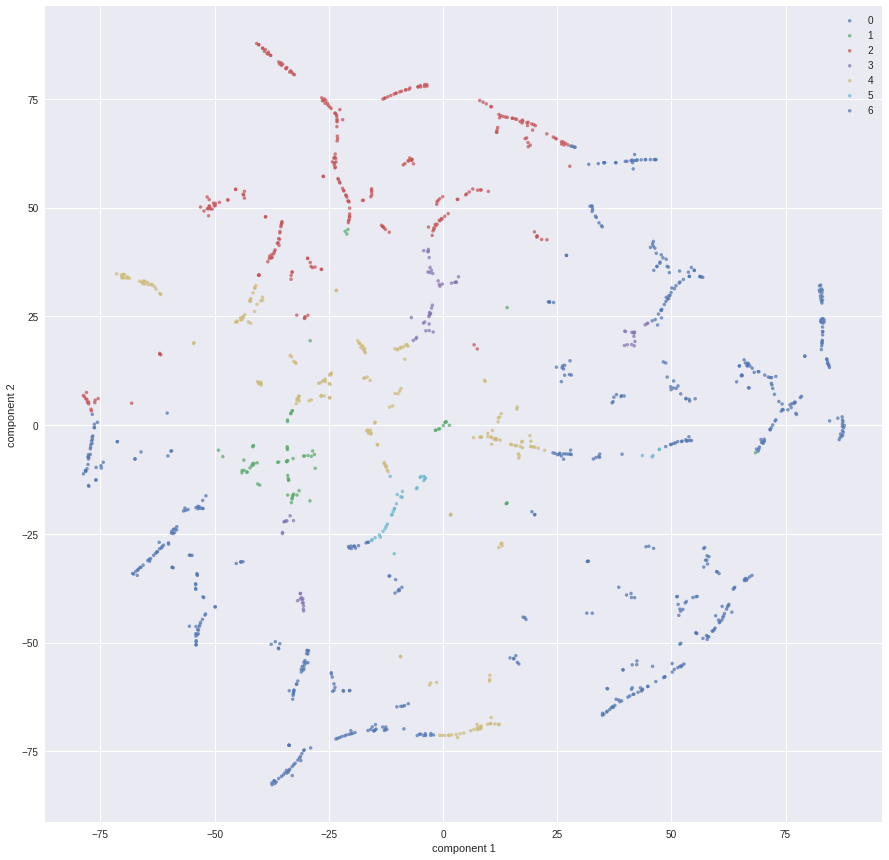

In [14]:
## YOUR CODE HERE
def make_plot(lda_mat):
    
    fig = plt.figure(figsize=(15,15), facecolor='white')
    ax = fig.add_subplot(111)
    
    tsne = TSNE(n_components=2, perplexity=10, init='pca')
    projected = tsne.fit_transform(lda_mat)
    
#     pca = PCA(n_components=2)
#     projected = pca.fit_transform(lda_mat)
    
    for class_num in np.arange(n_topics):
        topic_inds = np.where(lda_mat[:, class_num] > 0.5)[0]
        ax.scatter(projected[topic_inds, 0],
                   projected[topic_inds, 1], 
                   edgecolor='none', marker='.', alpha=0.7, label=str(class_num))

    ax.set_xlabel('component 1')
    ax.set_ylabel('component 2')
    ax.legend()
    
    
make_plot(lda_transformed)